### Importing modules

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import joblib
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
%matplotlib inline

Load and explore the data.

In [2]:
data = pd.read_csv("/Loan_Data.csv")

In [3]:
data.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


Data Types:

In [4]:
data.dtypes

,0
customer_id,int64
credit_lines_outstanding,int64
loan_amt_outstanding,float64
total_debt_outstanding,float64
income,float64
years_employed,int64
fico_score,int64
default,int64


Missing Data:

In [5]:
data.isnull().sum()

,0
customer_id,0
credit_lines_outstanding,0
loan_amt_outstanding,0
total_debt_outstanding,0
income,0
years_employed,0
fico_score,0
default,0


Outliers:

In [6]:
data_mod = data.drop("customer_id", axis=1)
for i in data_mod.columns:
  print (f"{i} ranges from {data[i].min()} to {data[i].max()}")

credit_lines_outstanding ranges from 0 to 5
loan_amt_outstanding ranges from 46.7839734 to 10750.67781
total_debt_outstanding ranges from 31.65273156 to 43688.7841
income ranges from 1000.0 to 148412.1805
years_employed ranges from 0 to 10
fico_score ranges from 408 to 850
default ranges from 0 to 1


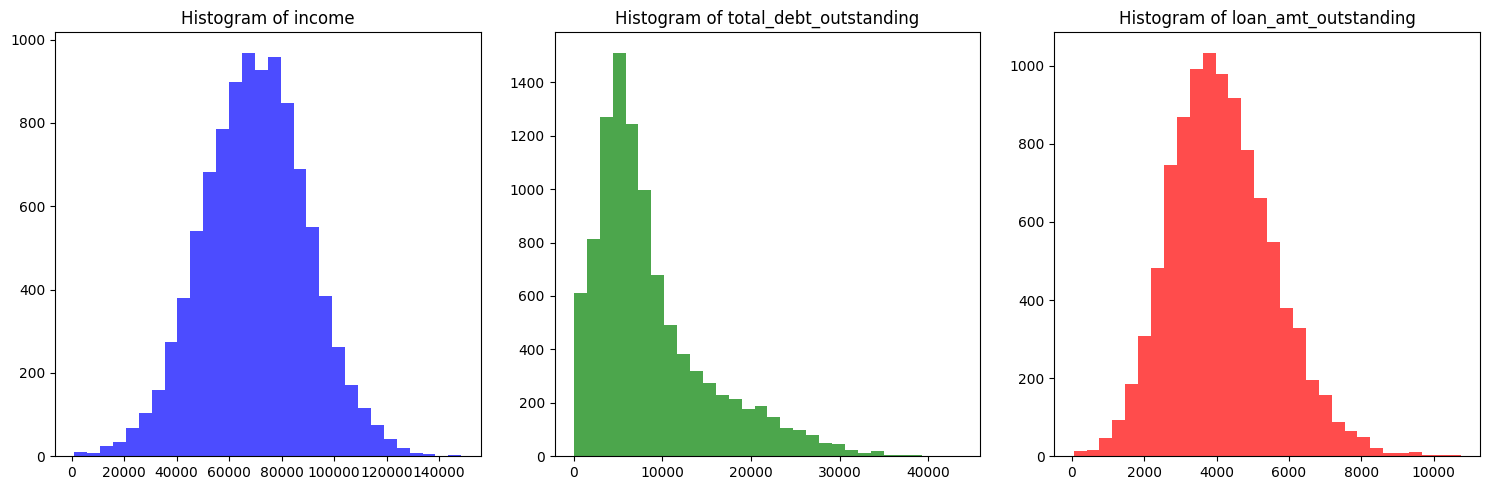

In [7]:
def plot_hist(df, column1, column2, column3):
    '''plot histogram distribution for different columns'''

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].hist(df[column1], bins=30, color='blue', alpha=0.7)
    ax[1].hist(df[column2], bins=30, color='green', alpha=0.7)
    ax[2].hist(df[column3], bins=30, color='red', alpha=0.7)

    ax[0].set_title(f'Histogram of {column1}')
    ax[1].set_title(f'Histogram of {column2}')
    ax[2].set_title(f'Histogram of {column3}')

    plt.tight_layout()
    plt.show()

plot_hist(data, 'income', 'total_debt_outstanding', 'loan_amt_outstanding')


Outlier transformation:
1. Z-score for normally distributed: plot 1 and 3
2. IQR for skewed data: plot 2

In [8]:
def z_score_outlier_filter(data, column, threshold=3):
    """Removes outliers using the Z-score method."""
    upper_limit = data[column].mean() + threshold * data[column].std()
    lower_limit = data[column].mean() - threshold * data[column].std()
    return data[(data[column] <= upper_limit) & (data[column] >= lower_limit)]

# Step 1: Apply Z-score method for 'income' and 'loan_amt_outstanding'
filtered_data = z_score_outlier_filter(data, "income")
filtered_data = z_score_outlier_filter(filtered_data, "loan_amt_outstanding")

def iqr_outlier_filter(data, column, multiplier=1.5):
    """Removes outliers using the IQR method."""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

filtered_data = iqr_outlier_filter(filtered_data, "total_debt_outstanding")
cleaned_data = iqr_outlier_filter(filtered_data, "fico_score")

outliers = data[~data.index.isin(cleaned_data.index)]

cleaned_data.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


## Feature Selection: To avoid noise and overfitting from collinearity, I use pearson's correlation to pick relevant features.

In [9]:
data_mod.corr()

,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
credit_lines_outstanding,1.000000,0.080249,0.852210,0.022272,-0.087900,-0.258177,0.862815
loan_amt_outstanding,0.080249,1.000000,0.397403,0.835815,-0.158416,-0.031373,0.098978
total_debt_outstanding,0.852210,0.397403,1.000000,0.394397,-0.174353,-0.232246,0.758868
income,0.022272,0.835815,0.394397,1.000000,0.001814,-0.010528,0.016309
years_employed,-0.087900,-0.158416,-0.174353,0.001814,1.000000,0.255873,-0.284506
fico_score,-0.258177,-0.031373,-0.232246,-0.010528,0.255873,1.000000,-0.324515
default,0.862815,0.098978,0.758868,0.016309,-0.284506,-0.324515,1.000000


Highly Correlated:
1. Total_debt_outstanding and credit_lines_outstanding
2. Income and loan_amt_outstanding.
Income has only a 2% effect on default but could still be an important metric.
To choose which to retain between total debt and credit lines, I'll perform a quick feature importance test using decision trees.

In [10]:
X = cleaned_data.drop(["default", "customer_id",], axis=1)
y = cleaned_data["default"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=142)

# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=142)
rf_model.fit(X_train, y_train)

# Get feature importance scores
feature_importances = rf_model.feature_importances_

# Step 5: Create a DataFrame to visualize feature importance
features = X.columns
importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

print("Feature Importance Scores:")
print(importance_df)

Feature Importance Scores:
                    Feature  Importance
0  credit_lines_outstanding    0.551575
2    total_debt_outstanding    0.261112
4            years_employed    0.062491
3                    income    0.056538
5                fico_score    0.044132
1      loan_amt_outstanding    0.024152


The results show credit_lines has more relevance to our model than total_debt. But before taking any further action, I'll check to see the impact of eliminating total_debt.

In [11]:
# Remove total_debt
X_reduced = X.drop("total_debt_outstanding", axis=1)

# Re-train the model with reduced features
X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(X_reduced, y, test_size=0.3, random_state=142)
rf_model_reduced = RandomForestClassifier(n_estimators=100, random_state=142)
rf_model_reduced.fit(X_train_red, y_train_red)

# Compare the performance metrics of both models
baseline_accuracy = rf_model.score(X_test, y_test)
reduced_accuracy = rf_model_reduced.score(X_test_red, y_test_red)

print(f"Baseline Model Accuracy: {baseline_accuracy:.4f}")
print(f"Reduced Model Accuracy: {reduced_accuracy:.4f}")


Baseline Model Accuracy: 0.9914
Reduced Model Accuracy: 0.9939


Eliminating total debt increases the accuracy of our model by 0.1%. So, it won't be used to train the model.

## **Choosing a Model**

I'll use a function to evaluate the model with the best performance from:


*   Logistic Regression
*   Random Forest Tree
*   Gradient Boosting (XGBoost)
*   K-Nearest Neighbours (KNN)
*   Support Vector Machines (SVM)


In [12]:
x = cleaned_data.drop(["default", "customer_id", "total_debt_outstanding",], axis=1)
y = cleaned_data["default"]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=123)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train and evaluate a model
def train_and_evaluate_model(model_name,model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    joblib.dump(model, f'{model_name}_model.joblib')
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(solver="lbfgs"),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'SVM': SVC(probability=True)  # SVM needs probability=True to get prob estimates
}


# Store accuracy results
accuracy_results = {}

for model_name, model in models.items():
    accuracy = train_and_evaluate_model(model_name, model, X_train_scaled, y_train, X_test_scaled, y_test)
    accuracy_results[model_name] = accuracy

accuracy_df = pd.DataFrame(list(accuracy_results.items()), columns=['Model', 'Accuracy'])
print(accuracy_df)

best_model_name = accuracy_df.loc[accuracy_df['Accuracy'].idxmax(), 'Model']
print (f"The best performing model is {best_model_name}")

                 Model  Accuracy
0  Logistic Regression  0.995685
1                  KNN  0.993168
2        Random Forest  0.996764
3              XGBoost  0.996045
4                  SVM  0.991730
The best performing model is Random Forest


The best performing model is Random Forest


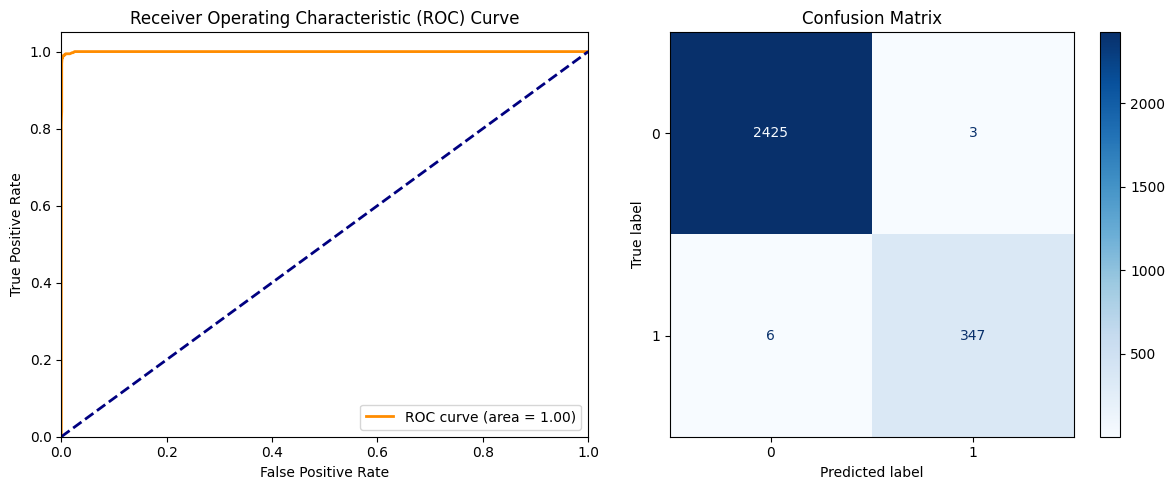

In [13]:
def plot_roc_and_confusion_matrix(model, X_test, y_test):
    """
    Plots the ROC curve and confusion matrix for the input model.

    Parameters:
    model: The trained model to evaluate.
    X_test: Scaled test features.
    y_test: True labels for the test set.
    """
    # Get predicted probabilities for the ROC curve
    y_prob = model.predict_proba(X_test)[:, 1]  # Use positive class probabilities

    # Compute ROC curve and ROC area
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')

    # Get confusion matrix
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    # Plot confusion matrix
    plt.subplot(1, 2, 2)
    disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
    plt.title('Confusion Matrix')

    plt.tight_layout()
    plt.show()

# Example usage with the best performing model:
best_model = models[best_model_name]
print(f"The best performing model is {best_model_name}")
plot_roc_and_confusion_matrix(best_model, X_test_scaled, y_test)


# **Final Solution to Task Using Gradient Boosting (XGBoost)**

In [14]:
import pandas as pd
import joblib

# Load the pre-trained XGBoost model
model = joblib.load("/content/Random Forest_model.joblib")  # Adjust path if necessary

def predict_default_and_loss(income, total_debt,
                             credit_lines, loan_amt, emp_length,
                             fico_score, recovery_rate=0.10):
    """
    Predict the probability of default and expected loss using a pre-trained XGBoost model.

    Args:
    - income (float): Annual income of the borrower.
    - total_debt : Total loan owed
    - credit_lines (int): Number of credit lines outstanding.
    - loan_amt (float): Loan amount in dollars.
    - emp_length (int): Years of employment.
    - fico_score (int): Interest rate on the loan (%).
    - recovery_rate (float): The percentage of the loan amount recoverable after default (default is 0.10 or 10%).

    Returns:
    - prob_default (float): Probability of default (between 0 and 1).
    - expected_loss (float): Calculated expected loss in dollars.
    """

    # Prepare input data as a DataFrame
    input_data = pd.DataFrame(
        [[income, total_debt, credit_lines, loan_amt, emp_length, fico_score]],
        columns=["total_debt", 'credit_lines_outstanding', 'emp_length', 'income', 'fico_score', 'loan_amt', ]
    )
    input_data = input_data.drop(["total_debt"], axis=1)

    # Predict the probability of default (PD)
    prob_default = model.predict_proba(input_data)[:, 1][0]

    # Calculate the expected loss
    expected_loss = loan_amt * (1 - recovery_rate) * prob_default

    return prob_default, expected_loss


In [15]:
# Example use:
credit_lines = 1
total_debt = 9000
income = 500000.0
emp_length = 9
fico_score = 700
loan_amt =2000.0

pd_default, loss = predict_default_and_loss(income, total_debt, credit_lines, loan_amt, emp_length, fico_score)
print(f"Probability of Default: {pd_default:.2%}")
print(f"Expected Loss: ${loss:,.2f}")

Probability of Default: 56.00%
Expected Loss: $1,008.00


In [16]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 5.6 MB/s eta 0:00:00


In [17]:
import streamlit as st

st.title("Loan Default and Prediction App")
st.header("Enter Borrower Details:")

# Input fields
income = st.number_input("Annual Income ($)", min_value=0.0, value=50000.0)
total_debt = st.number_input("Total Debt ($)", min_value=0.0, value=10000.0)
credit_lines = st.number_input("Number of Credit Lines", min_value=0, value=5)
loan_amt = st.number_input("Loan Amount ($)", min_value=0.0, value=15000.0)
emp_length = st.number_input("Years of Employment", min_value=0, value=2)
fico_score = st.number_input("FICO Score", min_value=300, max_value=850, value=700)

# Button to trigger prediction
if st.button("Predict"):
    prob_default, expected_loss = predict_default_and_loss(
        income, total_debt, credit_lines, loan_amt, emp_length, fico_score
    )

    # Display the results
    st.success(f"Probability of Default: {prob_default:.2%}")
    st.success(f"Expected Loss: ${expected_loss:,.2f}")

2024-10-20 22:54:06.444 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-20 22:54:06.811 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2024-10-20 22:54:06.814 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-20 22:54:06.819 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-20 22:54:06.821 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-20 22:54:06.827 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-20 22:54:06.828 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-20 22:54:06.829 Thread 'MainThread': mi